# MeerKAT  Audit Report
## June 2020

This report extracts data from the MeerKAT data archive.

Load all the package dependencies for the analysis

In [1]:
%pylab inline

import datetime
import katpoint
import calendar
import pysolr
from IPython.core.display import display, HTML


Populating the interactive namespace from numpy and matplotlib


Query the data archive for all entries for the specified month

In [2]:
prod = 'MeerKATTelescopeProduct'
archive = pysolr.Solr('http://kat-archive.kat.ac.za:8983/solr/kat_core')
search_str = []
search_str.append('CAS.ProductTypeName:%s'%prod)
search_str.append('StartTime:[2020-06-01T00:00:00Z TO 2020-07-01T00:00:00Z]')
search_string = ' AND '.join(search_str)
res = archive.search( search_string ,rows=10000,sort='StartTime desc')
print ("Number of observations in the archive: %d"%(res.hits))


Number of observations in the archive: 716


In [3]:
start = datetime.datetime.strptime(res.docs[-1]['StartTime'],'%Y-%m-%dT%H:%M:%SZ')
end = datetime.datetime.strptime(res.docs[0]['StartTime'],'%Y-%m-%dT%H:%M:%SZ')
print (start)
print (end)

2020-06-01 01:15:31
2020-06-30 23:17:12


In [4]:
first_timestamp = int(res.docs[-1]['CaptureBlockId'])
last_timestamp = int(res.docs[0]['CaptureBlockId']) + int(res.docs[0]['Duration'])

print (first_timestamp," --- ", katpoint.Timestamp(first_timestamp).local())
print (last_timestamp," --- ", katpoint.Timestamp(last_timestamp).local())
year = katpoint.Timestamp(first_timestamp).local().split()[0].split('-')[0]
month = katpoint.Timestamp(first_timestamp).local().split()[0].split('-')[1]

1590974125  ---  2020-06-01 03:15:25 SAST
1593570510  ---  2020-07-01 04:28:30 SAST


From the search results extract the Program_id to identify the science case and the duration and number of antennas for each observation. 

Sum the duration of each of the observations and express it as a percentage of the total time.

In [5]:
program_id = []
duration = []
antennas = []
for fi in res.docs:
    # now try extract the project-id from the instruction-set string
    try:
        program_id.append(fi['ProposalId'])
    except:
        program_id.append('No-project-id')
    duration.append(fi['Duration'])
    antennas.append(len(fi['Antennas']))
program_id = array(program_id)
duration = array(duration)
antennas = array(antennas)
total_time = last_timestamp - first_timestamp
p_cent = (sum(duration)/(total_time))*100

print ('Percentage system usage: %4.2f%%'%p_cent)

Percentage system usage: 104.06%


Break down the system usage per number of antennas used

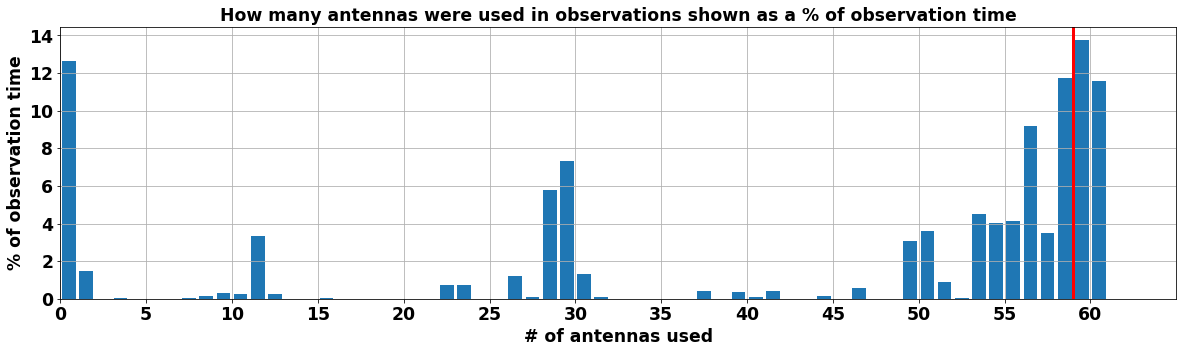

In [6]:
figure(figsize=(20,5))
p_cent = []
for i in range(1,65):
    ind = antennas == i
    p_cent.append((sum(duration[ind])/((end.toordinal()-start.toordinal())*24*3600))*100)
    #print i,p_cent[-1]
bar(arange(1,65)-0.5,p_cent)
xlim(1,65)
grid()
xticks(range(0,65,5))
yticklabels = getp(gca(), 'yticklabels')
setp(yticklabels, fontsize='xx-large',weight='bold');
xticklabels = getp(gca(), 'xticklabels')
setp(xticklabels, fontsize='xx-large',weight='bold');
xlabel('# of antennas used', fontsize='xx-large',weight='bold')
ylabel('% of observation time', fontsize='xx-large',weight='bold')
title('How many antennas were used in observations shown as a % of observation time', fontsize='xx-large',weight='bold')
axvline(59,color='r',linewidth=3)

Find the unique project ids and determine the total observation duration per program_id.

In [7]:
unique_program_id = []
time_per_program_id = []
for p in set(program_id):
    ind = program_id == p
    unique_program_id.append(p)
    time_per_program_id.append(sum(duration[ind]))

Print each unique observation by program_id and show its portion of the total observed time.

In [8]:
ind = argsort(time_per_program_id)
total_obs_time =  sum(time_per_program_id)
h = '<BR><table>'
h += "<tr><td colspan='4'>Telescope Usage</td></tr>"
h += "<tr><td>Program id<td>Time[hrs]<td>% usage<td>% of total</tr>"
#print 'Program id \t Time[hrs] \t %usage'
for i in reversed(ind):
    h += '<tr><td> %s <td> %.2f <td> %.2f <td> %.2f </tr>'% (unique_program_id[i],
                                                   time_per_program_id[i]/3600,
                                                   time_per_program_id[i]/total_obs_time *100.,
                                                   time_per_program_id[i]/total_time * 100.)
h += "<tr><td colspan='4'>...</td></tr>"
h += "</table>"
h += "<BR>"
display(HTML(h))

Telescope Usage
...


Plot as pie-chart

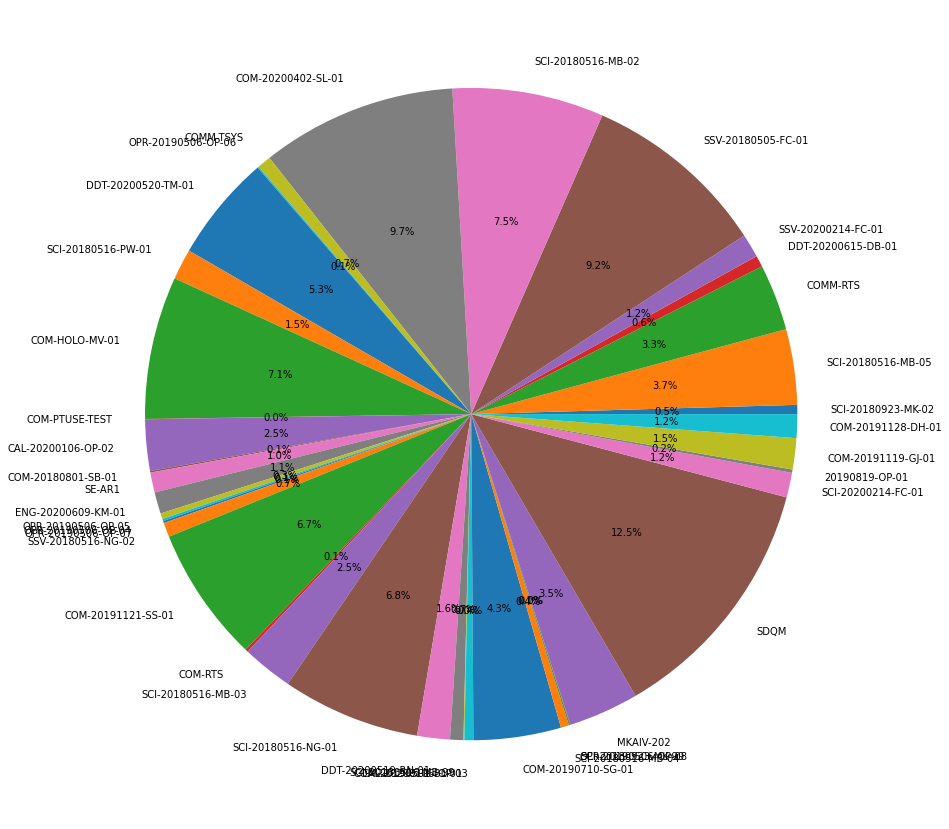

In [9]:
figure(figsize=(15,15))
pie(time_per_program_id,labels=unique_program_id,autopct='%1.1f%%');

The observations can be referenced back to their original request by querying the Google spreadsheet TAC control register.

NB this needs to be updated to the new repo for programs.

https://docs.google.com/a/ska.ac.za/spreadsheet/ccc?key=0AtlI2SwTgOz0dFBOZF9KRDV1YVN4d3pJcjE4Q01oeXc#gid=0

In [10]:
print ('Report generated:')
!date

Report generated:
Thu Jul  2 18:08:14 SAST 2020
